AutoGAN Model

Load,EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


In [2]:
# Load the datasets
transactions_df = pd.read_csv('../data/updated_fraud_transactions.csv')
customers_df = pd.read_csv('../data/customer_dataset 1.csv')

# Display the first few rows of each dataset
print(transactions_df.head())
print(customers_df.head())
merged_df = pd.merge(transactions_df, customers_df, left_on='Sender Account ID', right_on='Customer ID')


  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  
0     In  4887.67          B0004      0  
1     In  2371.33         B00010      0  
2     In  4733.44          B0008      0  
3     In  1544.12          B0005      0  
4    Out  3978.04          B0004      0  
   Customer ID                Name  Age      Location  Gender Account Type  \
0        10001      Nimal Fernando   61        Jaffna  Female      Savings   
1        10002  Sunil Samarasinghe   60        Jaffna   Other      Current   
2        10003    Ruwan Jayasinghe   67         Gal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Transaction ID     100000 non-null  object 
 1   Timestamp          100000 non-null  object 
 2   Sender Account ID  100000 non-null  int64  
 3   Transaction Type   100000 non-null  object 
 4   IN_OUT             100000 non-null  object 
 5   Amount             100000 non-null  float64
 6   Recipient Bank     100000 non-null  object 
 7   Fraud              100000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Customer ID   100 non-null    int64 
 1   Name          100 non-null    object
 2   Age           100 non-null    int64 
 3   Location      10

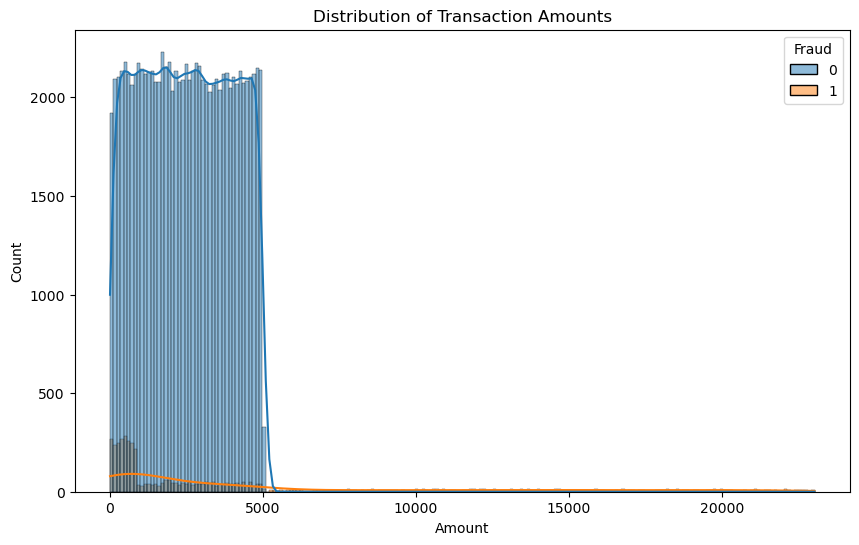

In [3]:
# Basic exploration
print(transactions_df.info())
print(customers_df.info())

# Check class distribution
print(transactions_df['Fraud'].value_counts(normalize=True))

# Visualize transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data=transactions_df, x='Amount', hue='Fraud', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()



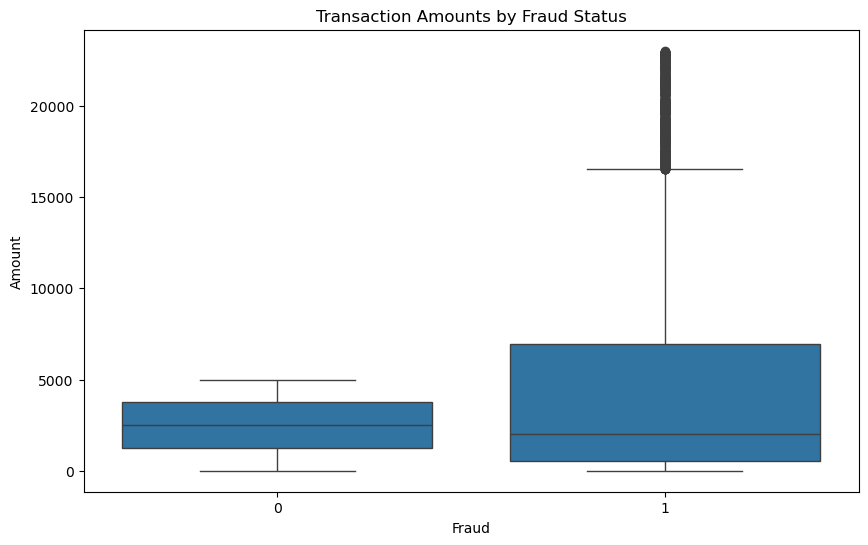

In [5]:
# Visualize transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

In [6]:
# Outlier detection and treatment (example using IQR method for 'Amount')
Q1 = merged_df['Amount'].quantile(0.25)
Q3 = merged_df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_df['Amount'] = np.where(merged_df['Amount'] > upper_bound, upper_bound, merged_df['Amount'])
merged_df['Amount'] = np.where(merged_df['Amount'] < lower_bound, lower_bound, merged_df['Amount'])

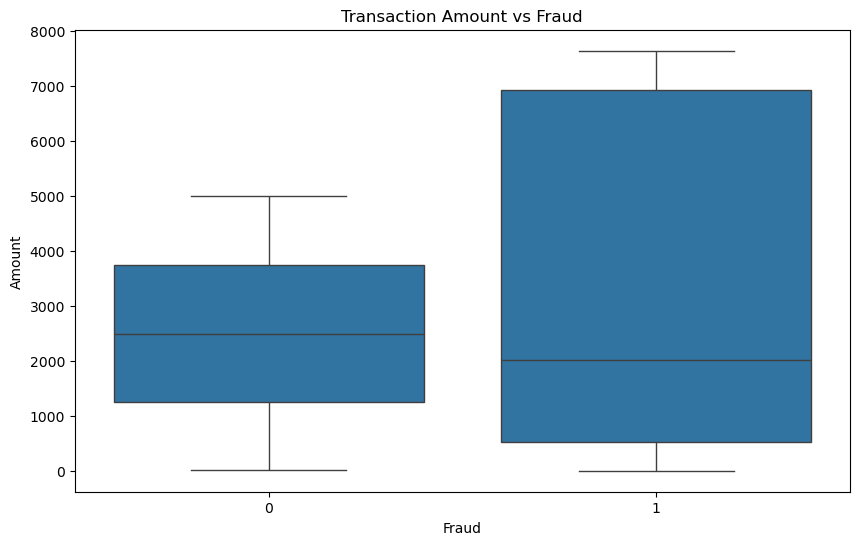

In [7]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [55]:
df = merged_df

In [56]:
df.head()

,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud,Customer ID,Name,Age,Location,Gender,Account Type,Device Count
0,T00001,2023-08-14 08:37:07,10095,Transfer,In,4887.67,B0004,0,10095,Dilshan De Alwis,59,Batticaloa,Male,Savings,10
1,T00002,2023-12-04 12:54:11,10098,Transfer,In,2371.33,B00010,0,10098,Ruwan Samarasinghe,60,Matara,Male,Savings,10
2,T00003,2023-07-09 23:16:11,10097,Credit,In,4733.44,B0008,0,10097,Sarath Dias,64,Jaffna,Other,Current,8
3,T00004,2023-06-26 07:04:39,10039,Credit,In,1544.12,B0005,0,10039,Nadeeka Dias,60,Kandy,Other,Current,1
4,T00005,2023-09-28 02:40:56,10018,Debit,Out,3978.04,B0004,0,10018,Chathura Hettiarachchi,36,Ratnapura,Other,Savings,4


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Ensure Timestamp is in datetime format and sort the dataframe
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['Sender Account ID', 'Timestamp']).reset_index(drop=True)

# Existing features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['AmountLog'] = np.log1p(df['Amount'])
df['AmountPerDevice'] = df['Amount'] / df['Device Count']
transaction_frequency = df.groupby('Sender Account ID')['Transaction ID'].count()
df['TransactionFrequency'] = df['Sender Account ID'].map(transaction_frequency)
df['IsHighRiskLocation'] = df['Location'].isin(['Colombo', 'Negombo', 'Kandy']).astype(int)
df['IsNewCustomer'] = (df['Age'] < 25).astype(int)

# New time-based features
df['DayOfMonth'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 5)).astype(int)

# Custom function for time-based features
def calculate_time_based_features(group, window_days):
    end_times = group['Timestamp']
    start_times = end_times - pd.Timedelta(days=window_days)
    
    counts = []
    amounts = []
    
    for start, end in zip(start_times, end_times):
        mask = (group['Timestamp'] > start) & (group['Timestamp'] <= end)
        counts.append(mask.sum())
        amounts.append(group.loc[mask, 'Amount'].sum())
    
    return pd.Series({
        f'TransactionCount_{window_days}d': counts,
        f'TransactionAmount_{window_days}d': amounts
    })

# Transaction velocity features
time_windows = [1, 7, 30]  # in days
for window in time_windows:
    new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
    df = df.join(new_features, on='Sender Account ID')

# Amount statistics per customer
amount_stats = df.groupby('Sender Account ID')['Amount'].agg(['mean', 'std', 'min', 'max'])
df['AmountMean'] = df['Sender Account ID'].map(amount_stats['mean'])
df['AmountStd'] = df['Sender Account ID'].map(amount_stats['std'])
df['AmountMin'] = df['Sender Account ID'].map(amount_stats['min'])
df['AmountMax'] = df['Sender Account ID'].map(amount_stats['max'])
df['AmountZScore'] = (df['Amount'] - df['AmountMean']) / df['AmountStd'].replace(0, 1)

# Behavioral features
df['TransactionTimeDiff'] = df.groupby('Sender Account ID')['Timestamp'].diff().dt.total_seconds() / 3600
df['TransactionAmountDiff'] = df.groupby('Sender Account ID')['Amount'].diff()
df['TransactionAmountRatio'] = df['Amount'] / df.groupby('Sender Account ID')['Amount'].shift(1)

# Advanced statistical features
df['AmountSkew'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: skew(x) if len(x) > 2 else 0)
df['AmountKurtosis'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: kurtosis(x) if len(x) > 3 else 0)

# Interaction features
df['AmountPerFrequency'] = df['Amount'] / (df['TransactionFrequency'] + 1)
df['AmountPerAge'] = df['Amount'] / (df['Age'] + 1)

# Categorical encoding
df['RecipientBankEncoded'] = df['Recipient Bank'].map(df.groupby('Recipient Bank')['Fraud'].mean())
df['LocationEncoded'] = df['Location'].map(df.groupby('Location')['Fraud'].mean())

# Fill NaN values
df = df.fillna(0)

print(df.columns)
print(df.head())

/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_92016/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_92016/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').appl

Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')
  Transaction ID           Timestamp  Sender Account ID Transaction Type  \
0         T10171 2023-01-01 02:15:40       

/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_92016/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))


In [58]:
# Print the column names to verify
print("Columns in the dataframe:")
print(df.columns)

Columns in the dataframe:
Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')


In [59]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select all features except 'Fraud' (target variable) and any non-numeric columns
feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Fraud')


In [60]:
# Perform feature selection
selector = SelectKBest(f_classif, k=20)  # Select top 20 features
X_selected = selector.fit_transform(df[feature_cols], df['Fraud'])


In [61]:
# Get selected feature names
selected_features = feature_cols[selector.get_support()].tolist()

print("Selected features:", selected_features)


Selected features: ['Sender Account ID', 'Amount', 'Customer ID', 'Weekend', 'AmountLog', 'AmountPerDevice', 'TransactionFrequency', 'IsNightTime', 'AmountMean', 'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore', 'TransactionAmountDiff', 'AmountSkew', 'AmountKurtosis', 'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded', 'LocationEncoded']


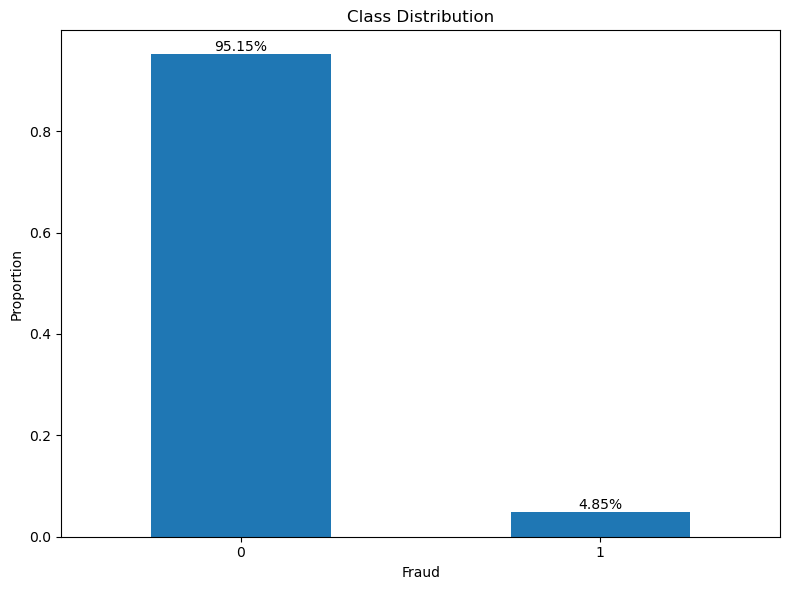

Class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64


In [62]:
import matplotlib.pyplot as plt

class_distribution = df['Fraud'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
for i, v in enumerate(class_distribution):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("Class distribution:")
print(class_distribution)

In [63]:
X = df[selected_features]
y = df['Fraud']


In [64]:
# 6. Data Balancing
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_balanced, y_balanced = rus.fit_resample(*smote.fit_resample(X, y))


In [65]:
print("Original dataset shape:", X.shape)
print("Balanced dataset shape:", X_balanced.shape)
print("\nOriginal class distribution:")
print(y.value_counts(normalize=True))
print("\nBalanced class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))


Original dataset shape: (100000, 20)
Balanced dataset shape: (115534, 20)

Original class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64

Balanced class distribution:
Fraud
0    0.588234
1    0.411766
Name: proportion, dtype: float64


In [66]:
# 7. Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [67]:
# 8. Feature Scaling / Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [68]:
# Separate normal and fraudulent transactions
X_train_normal = X_train_scaled[y_train == 0]
X_train_fraud = X_train_scaled[y_train == 1]

AutoGAN model

In [34]:
# AnoGAN Model
def build_generator(latent_dim, output_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(latent_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

def build_discriminator(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

class AnoGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(AnoGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(AnoGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(latent_vector, training=True)

            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)

            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            disc_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                        self.loss_fn(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"g_loss": gen_loss, "d_loss": disc_loss}

In [35]:
# Hyperparameters
latent_dim = 100
input_dim = X_train_scaled.shape[1]
batch_size = 32
epochs = 500

# Build and compile the model
wgan = WGAN(latent_dim, input_dim, critic_extra_steps=3)
wgan.compile(
    g_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9),
    c_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
)

In [77]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

class AnoGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(AnoGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(AnoGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            generated_data = self.generator(latent_vector, training=True)
            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            
            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            generated_data = self.generator(latent_vector, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return {"g_loss": gen_loss, "d_loss": disc_loss}

# Improved generator with batch normalization and LeakyReLU
def build_generator(latent_dim, output_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, input_shape=(latent_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

# Improved discriminator with dropout and LeakyReLU
def build_discriminator(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(256, input_shape=(input_dim,)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [78]:
# Set hyperparameters
latent_dim = 100
output_dim = X_train_scaled.shape[1]
learning_rate = 0.0002
beta_1 = 0.5


In [79]:
# Build and compile the model
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)

anogan = AnoGAN(generator, discriminator, latent_dim)
anogan.compile(
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

In [80]:
# Training loop with label smoothing and noise addition
epochs = 100
batch_size = 32

for epoch in range(epochs):
    for batch in range(0, len(X_train_scaled), batch_size):
        batch_data = X_train_scaled[batch:batch+batch_size]
        
        # Add noise to the real data
        noise = np.random.normal(0, 0.1, batch_data.shape)
        noisy_batch = batch_data + noise
        
        # Label smoothing
        real_labels = np.random.uniform(0.8, 1.0, size=(len(noisy_batch), 1))
        fake_labels = np.random.uniform(0.0, 0.2, size=(len(noisy_batch), 1))
        
        # Train step
        loss = anogan.train_step(noisy_batch)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, G_loss: {loss['g_loss']:.4f}, D_loss: {loss['d_loss']:.4f}")


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 10/100, G_loss: 3.1559, D_loss: 0.3809
Epoch 20/100, G_loss: 3.3791, D_loss: 0.2708
Epoch 30/100, G_loss: 3.5772, D_loss: 0.1693
Epoch 40/100, G_loss: 4.0142, D_loss: 0.0232
Epoch 50/100, G_loss: 3.7596, D_loss: 0.0211
Epoch 60/100, G_loss: 3.7228, D_loss: 0.0242
Epoch 70/100, G_loss: 3.5645, D_loss: 0.0203
Epoch 80/100, G_loss: 4.1776, D_loss: 0.1282
Epoch 90/100, G_loss: 3.7263, D_loss: 0.0200
Epoch 100/100, G_loss: 4.5642, D_loss: 0.0264


In [81]:
# Function to detect anomalies
def detect_anomalies(model, data, threshold):
    latent_vector = tf.random.normal(shape=(len(data), model.latent_dim))
    generated_data = model.generator(latent_vector)
    reconstruction_error = tf.reduce_mean(tf.square(data - generated_data), axis=1)
    return reconstruction_error > threshold


In [83]:
def compute_reconstruction_error(model, data):
    latent_vector = tf.random.normal(shape=(len(data), model.latent_dim))
    generated_data = model.generator(latent_vector)
    reconstruction_error = tf.reduce_mean(tf.square(data - generated_data), axis=1)
    return reconstruction_error.numpy()

In [84]:
# Compute reconstruction errors for validation set
val_errors = compute_reconstruction_error(anogan, X_val_scaled)

# Set threshold at 95th percentile of validation errors
threshold = np.percentile(val_errors, 95)

# Compute reconstruction errors for test set
test_errors = compute_reconstruction_error(anogan, X_test_scaled)

# Predict anomalies
y_pred = (test_errors > threshold).astype(int)

In [86]:
# Evaluate the model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
auc_roc = roc_auc_score(y_test, y_pred)

In [87]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Precision: 0.6573
Recall: 0.0823
F1-score: 0.1462
AUC-ROC: 0.5261


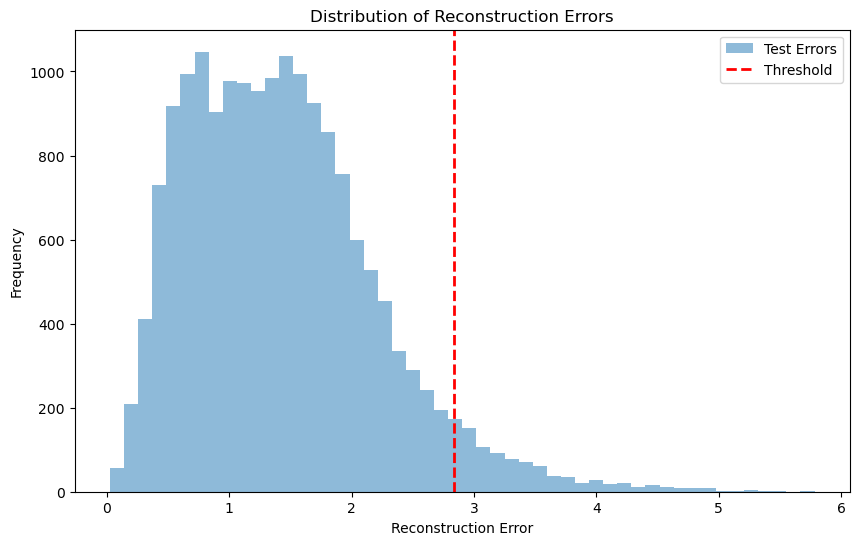

In [88]:
# Optional: Plot the distribution of reconstruction errors
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(test_errors, bins=50, alpha=0.5, label='Test Errors')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

In [42]:
# Normalize anomaly scores
anomaly_scores_normalized = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))


In [91]:
# Classification Report
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.97      0.74     10195
           1       0.66      0.08      0.15      7136

    accuracy                           0.60     17331
   macro avg       0.63      0.53      0.44     17331
weighted avg       0.62      0.60      0.50     17331



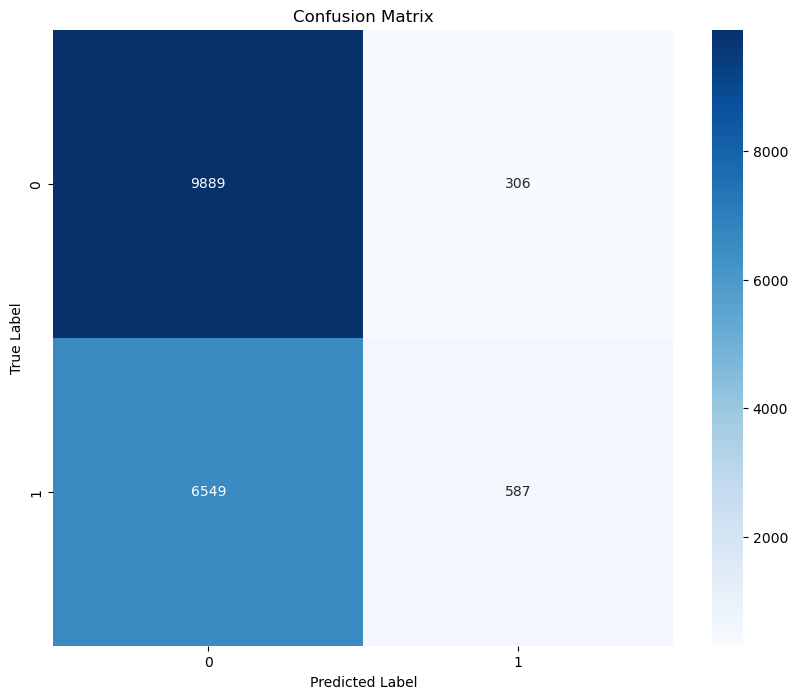

In [92]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Evaluate Results

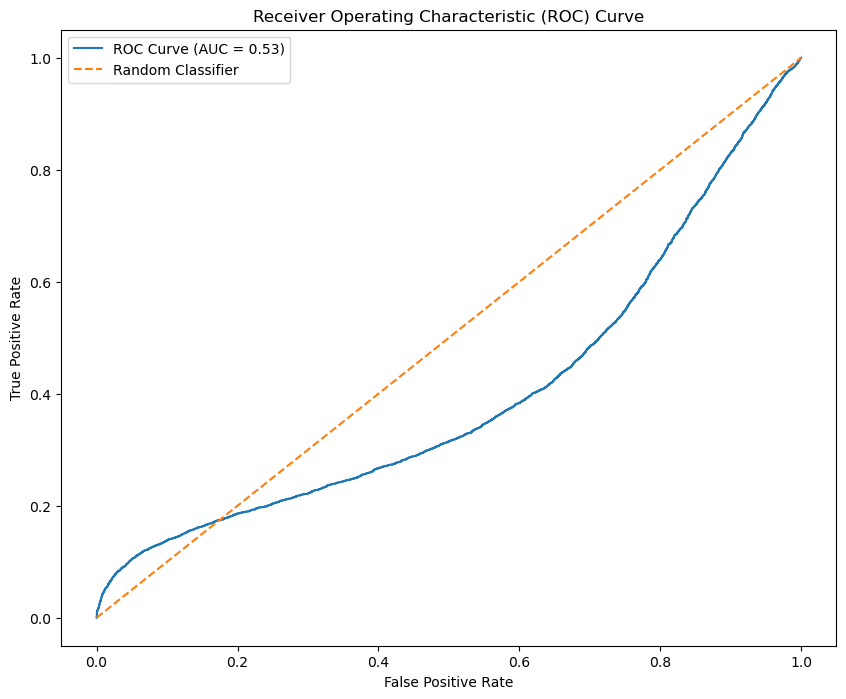

In [93]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, test_errors)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

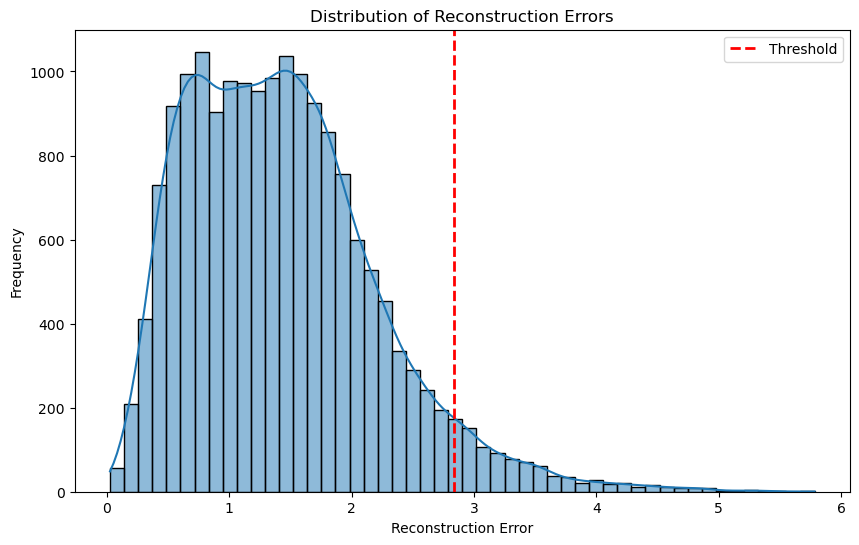

In [94]:
# Distribution of Reconstruction Errors
plt.figure(figsize=(10, 6))
sns.histplot(test_errors, kde=True, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

In [95]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Anomaly_Score': anomaly_scores_normalized
})

# Display the first few rows of the results
print("\nSample of Actual vs Predicted Values:")
print(results_df.head(20))


Sample of Actual vs Predicted Values:
        Actual  Predicted  Anomaly_Score
22872        0          0       0.283596
57016        0          0       0.298697
135912       1          0       0.516566
47629        0          0       0.393097
122161       1          0       0.249417
138964       1          0       0.300278
57552        0          0       0.220680
79386        1          0       0.306106
22455        0          0       0.424405
104782       1          0       0.287049
32461        0          0       0.481128
118434       1          0       0.161043
115840       1          0       0.193079
41236        0          0       0.326930
111015       1          0       0.260880
79762        0          0       0.375417
102414       1          0       0.261829
105600       1          0       0.250283
129184       1          0       0.356797
78832        0          0       0.309570
